### Imports

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

### Download data

In [2]:
!wget "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
!unzip jena_climate_2009_2016.csv.zip

--2023-10-09 14:41:58--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 2607:f8b0:4023:c06::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  63.7MB/s    in 0.2s    

2023-10-09 14:41:59 (63.7 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


### Inspect data

In [3]:
df = pd.read_csv('jena_climate_2009_2016.csv')
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
# basic info check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [5]:
# Convert Date Time to datetime object
df['Date Time'] = pd.to_datetime(df['Date Time'])

### Plot of temperature over the years

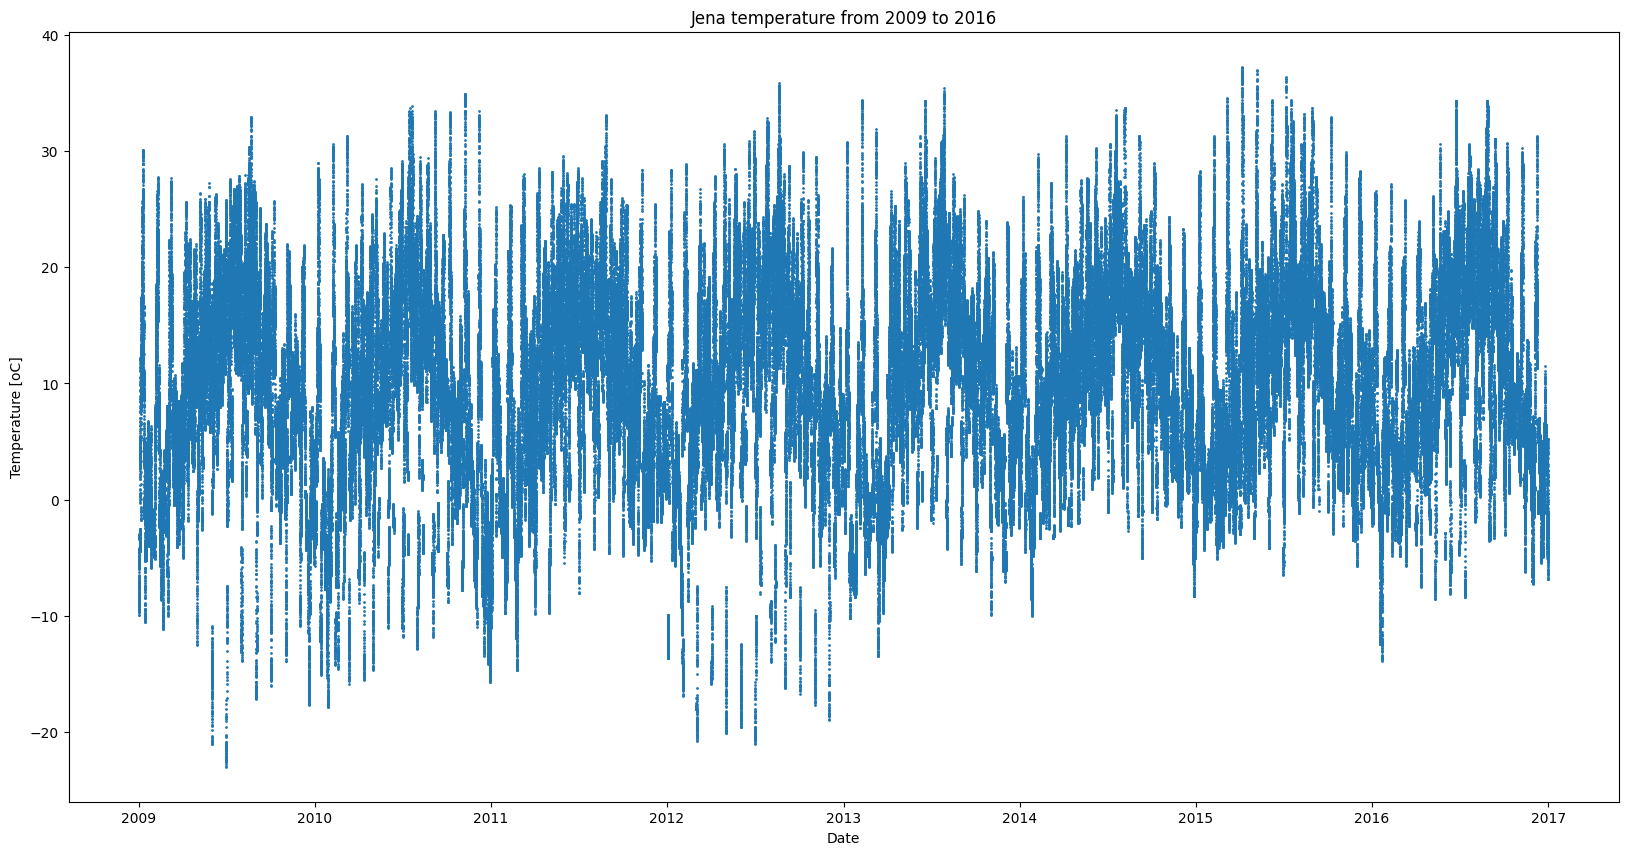

In [6]:
plt.figure(figsize = (20, 10))
plt.plot(df['Date Time'], df['T (degC)'], 'o', markersize = 1)
plt.xlabel('Date')
plt.ylabel('Temperature [oC]')
plt.title('Jena temperature from 2009 to 2016')
plt.show()

### Divide data into X (all features except date and temeprature) and y (temperature)

In [7]:
X = df.drop(columns = ['Date Time', 'T (degC)']).values
y = df['T (degC)'].values

### Split data into train, validation and test sets

In [8]:
TRAIN_PERCENTAGE = 0.5
VAL_PERCENTAGE = 0.25
TEST_PERCENTAGE = 0.25

# Training data
X_train = X[:int(TRAIN_PERCENTAGE * len(X)), :]
y_train = y[:int(TRAIN_PERCENTAGE * len(X))]

# Validation data
X_val = X[int(TRAIN_PERCENTAGE * len(X)): int( (TRAIN_PERCENTAGE + VAL_PERCENTAGE) * len(X)), :]
y_val = y[int(TRAIN_PERCENTAGE * len(X)): int( (TRAIN_PERCENTAGE + VAL_PERCENTAGE) * len(X))]

# Test data
X_test = X[int( (TRAIN_PERCENTAGE + VAL_PERCENTAGE) * len(X)): , :]
y_test = y[int( (TRAIN_PERCENTAGE + VAL_PERCENTAGE) * len(X)):]

print(len(X) == len(X_train) + len(X_val) + len(X_test))

True


### Data normalization

In [9]:
# Calculate mean and standard deviation from training data
mean = X_train.mean(axis = 0)
std = X_train.std(axis = 0)

# Normalize training data
X_train -= mean
X_train /= std

# Normalize rest of data using training mean and std
X_val -= mean
X_val /= std
X_test -= mean
X_test /= std

# Problem statement: given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?

### First step: create dataset consisting of 5 days windows using `timeseries_dataset_from_array` function

In [10]:
# Define important parameters
SAMPLING_RATE = 6 # since temperatures are measured once every 10 minutes, we take only 1 of 6 points
SEQUENCE_LENGTH = 120 # 120 hours = 5 days
DELAY = SAMPLING_RATE*(SEQUENCE_LENGTH + 24 - 1) # we want to predict temperature 24 hours after window ends
BATCH_SIZE = 256

train_dataset = tf.keras.utils.timeseries_dataset_from_array(data = X_train[:-DELAY],
                                                             targets = y_train[DELAY:],
                                                             sequence_length = SEQUENCE_LENGTH,
                                                             sampling_rate = SAMPLING_RATE,
                                                             batch_size = BATCH_SIZE,
                                                             shuffle = True)
val_dataset = tf.keras.utils.timeseries_dataset_from_array(data = X_val[:-DELAY],
                                                             targets = y_val[DELAY:],
                                                             sequence_length = SEQUENCE_LENGTH,
                                                             sampling_rate = SAMPLING_RATE,
                                                             batch_size = BATCH_SIZE,
                                                             shuffle = True)
test_dataset = tf.keras.utils.timeseries_dataset_from_array(data = X_test[:-DELAY],
                                                             targets = y_test[DELAY:],
                                                             sequence_length = SEQUENCE_LENGTH,
                                                             sampling_rate = SAMPLING_RATE,
                                                             batch_size = BATCH_SIZE,
                                                             shuffle = True)

In [11]:
# Check if dataset is created
for window, temperature in train_dataset:
  print(window.shape)
  print(temperature.shape)
  break

(256, 120, 13)
(256,)


### Building model (single LSTM cell with dropout followed by dense layer)

In [12]:
inputs = tf.keras.layers.Input(shape = (120, 13))
x = tf.keras.layers.LSTM(units = 32, recurrent_dropout = 0.2)(inputs) # recurrent_dropout regularization for recurrent layer
x = tf.keras.layers.Dropout(rate = 0.5)(x) # regularization for dense layer
outputs = tf.keras.layers.Dense(units = 1)(x)

model = tf.keras.models.Model(inputs = inputs, outputs = outputs)
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = './best_model',
                                                save_best_only = True,
                                                monitor = 'val_loss')]

model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'mse',
              metrics = ['mae'])

### Training model

In [13]:
history = model.fit(train_dataset,
                    epochs = 20,
                    validation_data = val_dataset,
                    callbacks = callbacks,
                    batch_size = 128)

Epoch 1/20
816/816 [==============================] - 377s 454ms/step - loss: 33.8409 - mae: 4.2957 - val_loss: 11.6325 - val_mae: 2.6073
Epoch 2/20
816/816 [==============================] - 366s 449ms/step - loss: 16.0764 - mae: 3.1069 - val_loss: 9.8718 - val_mae: 2.4395
Epoch 3/20
816/816 [==============================] - 368s 450ms/step - loss: 14.8328 - mae: 2.9886 - val_loss: 9.6930 - val_mae: 2.4129
Epoch 4/20
816/816 [==============================] - 368s 451ms/step - loss: 13.9530 - mae: 2.8977 - val_loss: 9.4393 - val_mae: 2.3982
Epoch 5/20
816/816 [==============================] - 363s 444ms/step - loss: 13.5455 - mae: 2.8491 - val_loss: 9.4989 - val_mae: 2.4123
Epoch 6/20
816/816 [==============================] - 362s 444ms/step - loss: 12.9490 - mae: 2.7866 - val_loss: 9.6539 - val_mae: 2.4368
Epoch 7/20
816/816 [==============================] - 359s 439ms/step - loss: 12.4870 - mae: 2.7355 - val_loss: 9.7666 - val_mae: 2.4408
Epoch 8/20
816/816 [====================

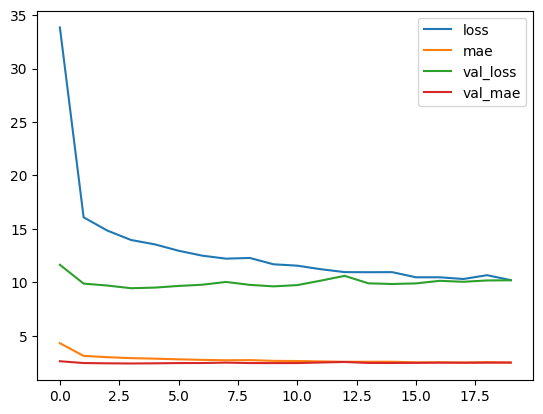

In [14]:
results = pd.DataFrame(history.history).plot()